[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana11/Portafolios_Reinforcement_Learning.ipynb)

# Descripción

En este notebook usaremos aprendizaje profundo por refuerzo (Deep Reinforcement Learning) para crear carteras de inversión. 

En el aprendizaje por refuerzo existen tres partes principales: El agente, el entorno y la recompensa.

El agente va a tratar de capturar los aspectos más importantes de problema interactuando con el entorno a través del tiempo, a cada "captura" de este le llamaremos estado. La interacción con es lo que se conoce acción: El agente toma una acción y "evalua" como afecta al entorno y la recompensa obtenida. 

La acción que el agente toma está dada por la política del modelo. En el enfoque estocástico de la política, la acción se toma basada en distribucion condicional de las acciones dado el estado. El enfoque determinístico hace que la acción esté en función del estado.

Para el problema de asignación de pesos en la cartera:

- El agente será una red neuroal (perceptrón multicapa) que genera los pesos del portafolio
- El estado será el estado del mercado en el periodo en cuestión, dado por la matriz de covarianza e indicadores basados en el precio y volumen de los activos/transacciones
- La recompensa será el retorno de la cartera que el agente creó.

Utilizaremos [```gym```](https://gym.openai.com/) de OpenAI para crear el entorno y [```stable_baselines```](https://stable-baselines.readthedocs.io/en/master/index.html) para que el agente aprenda. En particular, entrenaremos a 3 agentes con los algoritmos A2C, DDPG y PPO.

# Dependencias

In [ ]:
%%capture
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git@sr_tax_lots
# !pip install yfinance
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install numpy
!pip install matplotlib
# !pip install stockstats
!pip install gym
!pip install stable-baselines3[extra]
!pip install tensorflow
!pip install git+https://github.com/quantopian/pyfolio
!pip install ta
!pip install PyPortfolioOpt

In [ ]:
#@title Config.py
%%writefile config.py
import pathlib

# import finrl

import pandas as pd
import datetime
import os

# pd.options.display.max_rows = 10
# pd.options.display.max_columns = 10


# PACKAGE_ROOT = pathlib.Path(finrl.__file__).resolve().parent
# PACKAGE_ROOT = pathlib.Path().resolve().parent

# TRAINED_MODEL_DIR = PACKAGE_ROOT / "trained_models"
# DATASET_DIR = PACKAGE_ROOT / "data"

# data
TRAINING_DATA_FILE = "data/ETF_SPY_2009_2020.csv"
TURBULENCE_DATA = "data/dow30_turbulence_index.csv"
TESTING_DATA_FILE = "test.csv"

# now = datetime.datetime.now()
# TRAINED_MODEL_DIR = f"trained_models/{now}"
DATA_SAVE_DIR = f"datasets"
TRAINED_MODEL_DIR = f"trained_models"
TENSORBOARD_LOG_DIR = f"tensorboard_log"
RESULTS_DIR = f"results"
# os.makedirs(TRAINED_MODEL_DIR)


## time_fmt = '%Y-%m-%d'
START_DATE = "2009-01-01"
END_DATE = "2020-12-01"

START_TRADE_DATE = "2019-01-01"

## dataset default columns
DEFAULT_DATA_COLUMNS = ["date", "tic", "close"]

## stockstats technical indicator column names
## check https://pypi.org/project/stockstats/ for different names
TECHNICAL_INDICATORS_LIST = ["macd", "rsi_30", "cci_30", "dx_30"]


## Model Parameters
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0007}
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 64,
}
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
TD3_PARAMS = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}
SAC_PARAMS = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "batch_size": 64,
    "ent_coef": "auto_0.1",
}

########################################################
############## Stock Ticker Setup starts ##############
SINGLE_TICKER = ["AAPL"]

# self defined
MULTIPLE_STOCK_TICKER = ["AAPL", "MSFT", "FB"]

# check https://wrds-www.wharton.upenn.edu/ for U.S. index constituents
# Dow 30 constituents at 2019/01
DOW_30_TICKER = [
    "AAPL",
    "MSFT",
    "JPM",
    "V",
    "RTX",
    "PG",
    "GS",
    "NKE",
    "DIS",
    "AXP",
    "HD",
    "INTC",
    "WMT",
    "IBM",
    "MRK",
    "UNH",
    "KO",
    "CAT",
    "TRV",
    "JNJ",
    "CVX",
    "MCD",
    "VZ",
    "CSCO",
    "XOM",
    "BA",
    "MMM",
    "PFE",
    "WBA",
    "DD",
]

# Nasdaq 100 constituents at 2019/01
NAS_100_TICKER = [
    "AMGN",
    "AAPL",
    "AMAT",
    "INTC",
    "PCAR",
    "PAYX",
    "MSFT",
    "ADBE",
    "CSCO",
    "XLNX",
    "QCOM",
    "COST",
    "SBUX",
    "FISV",
    "CTXS",
    "INTU",
    "AMZN",
    "EBAY",
    "BIIB",
    "CHKP",
    "GILD",
    "NLOK",
    "CMCSA",
    "FAST",
    "ADSK",
    "CTSH",
    "NVDA",
    "GOOGL",
    "ISRG",
    "VRTX",
    "HSIC",
    "BIDU",
    "ATVI",
    "ADP",
    "ROST",
    "ORLY",
    "CERN",
    "BKNG",
    "MYL",
    "MU",
    "DLTR",
    "ALXN",
    "SIRI",
    "MNST",
    "AVGO",
    "TXN",
    "MDLZ",
    "FB",
    "ADI",
    "WDC",
    "REGN",
    "LBTYK",
    "VRSK",
    "NFLX",
    "TSLA",
    "CHTR",
    "MAR",
    "ILMN",
    "LRCX",
    "EA",
    "AAL",
    "WBA",
    "KHC",
    "BMRN",
    "JD",
    "SWKS",
    "INCY",
    "PYPL",
    "CDW",
    "FOXA",
    "MXIM",
    "TMUS",
    "EXPE",
    "TCOM",
    "ULTA",
    "CSX",
    "NTES",
    "MCHP",
    "CTAS",
    "KLAC",
    "HAS",
    "JBHT",
    "IDXX",
    "WYNN",
    "MELI",
    "ALGN",
    "CDNS",
    "WDAY",
    "SNPS",
    "ASML",
    "TTWO",
    "PEP",
    "NXPI",
    "XEL",
    "AMD",
    "NTAP",
    "VRSN",
    "LULU",
    "WLTW",
    "UAL",
]

# SP 500 constituents at 2019
SP_500_TICKER = [
    "A",
    "AAL",
    "AAP",
    "AAPL",
    "ABBV",
    "ABC",
    "ABMD",
    "ABT",
    "ACN",
    "ADBE",
    "ADI",
    "ADM",
    "ADP",
    "ADS",
    "ADSK",
    "AEE",
    "AEP",
    "AES",
    "AFL",
    "AGN",
    "AIG",
    "AIV",
    "AIZ",
    "AJG",
    "AKAM",
    "ALB",
    "ALGN",
    "ALK",
    "ALL",
    "ALLE",
    "ALXN",
    "AMAT",
    "AMCR",
    "AMD",
    "AME",
    "AMG",
    "AMGN",
    "AMP",
    "AMT",
    "AMZN",
    "ANET",
    "ANSS",
    "ANTM",
    "AON",
    "AOS",
    "APA",
    "APD",
    "APH",
    "APTV",
    "ARE",
    "ARNC",
    "ATO",
    "ATVI",
    "AVB",
    "AVGO",
    "AVY",
    "AWK",
    "AXP",
    "AZO",
    "BA",
    "BAC",
    "BAX",
    "BBT",
    "BBY",
    "BDX",
    "BEN",
    "BF.B",
    "BHGE",
    "BIIB",
    "BK",
    "BKNG",
    "BLK",
    "BLL",
    "BMY",
    "BR",
    "BRK.B",
    "BSX",
    "BWA",
    "BXP",
    "C",
    "CAG",
    "CAH",
    "CAT",
    "CB",
    "CBOE",
    "CBRE",
    "CBS",
    "CCI",
    "CCL",
    "CDNS",
    "CE",
    "CELG",
    "CERN",
    "CF",
    "CFG",
    "CHD",
    "CHRW",
    "CHTR",
    "CI",
    "CINF",
    "CL",
    "CLX",
    "CMA",
    "CMCSA",
    "CME",
    "CMG",
    "CMI",
    "CMS",
    "CNC",
    "CNP",
    "COF",
    "COG",
    "COO",
    "COP",
    "COST",
    "COTY",
    "CPB",
    "CPRI",
    "CPRT",
    "CRM",
    "CSCO",
    "CSX",
    "CTAS",
    "CTL",
    "CTSH",
    "CTVA",
    "CTXS",
    "CVS",
    "CVX",
    "CXO",
    "D",
    "DAL",
    "DD",
    "DE",
    "DFS",
    "DG",
    "DGX",
    "DHI",
    "DHR",
    "DIS",
    "DISCK",
    "DISH",
    "DLR",
    "DLTR",
    "DOV",
    "DOW",
    "DRE",
    "DRI",
    "DTE",
    "DUK",
    "DVA",
    "DVN",
    "DXC",
    "EA",
    "EBAY",
    "ECL",
    "ED",
    "EFX",
    "EIX",
    "EL",
    "EMN",
    "EMR",
    "EOG",
    "EQIX",
    "EQR",
    "ES",
    "ESS",
    "ETFC",
    "ETN",
    "ETR",
    "EVRG",
    "EW",
    "EXC",
    "EXPD",
    "EXPE",
    "EXR",
    "F",
    "FANG",
    "FAST",
    "FB",
    "FBHS",
    "FCX",
    "FDX",
    "FE",
    "FFIV",
    "FIS",
    "FISV",
    "FITB",
    "FLIR",
    "FLS",
    "FLT",
    "FMC",
    "FOXA",
    "FRC",
    "FRT",
    "FTI",
    "FTNT",
    "FTV",
    "GD",
    "GE",
    "GILD",
    "GIS",
    "GL",
    "GLW",
    "GM",
    "GOOG",
    "GPC",
    "GPN",
    "GPS",
    "GRMN",
    "GS",
    "GWW",
    "HAL",
    "HAS",
    "HBAN",
    "HBI",
    "HCA",
    "HCP",
    "HD",
    "HES",
    "HFC",
    "HIG",
    "HII",
    "HLT",
    "HOG",
    "HOLX",
    "HON",
    "HP",
    "HPE",
    "HPQ",
    "HRB",
    "HRL",
    "HSIC",
    "HST",
    "HSY",
    "HUM",
    "IBM",
    "ICE",
    "IDXX",
    "IEX",
    "IFF",
    "ILMN",
    "INCY",
    "INFO",
    "INTC",
    "INTU",
    "IP",
    "IPG",
    "IPGP",
    "IQV",
    "IR",
    "IRM",
    "ISRG",
    "IT",
    "ITW",
    "IVZ",
    "JBHT",
    "JCI",
    "JEC",
    "JEF",
    "JKHY",
    "JNJ",
    "JNPR",
    "JPM",
    "JWN",
    "K",
    "KEY",
    "KEYS",
    "KHC",
    "KIM",
    "KLAC",
    "KMB",
    "KMI",
    "KMX",
    "KO",
    "KR",
    "KSS",
    "KSU",
    "L",
    "LB",
    "LDOS",
    "LEG",
    "LEN",
    "LH",
    "LHX",
    "LIN",
    "LKQ",
    "LLY",
    "LMT",
    "LNC",
    "LNT",
    "LOW",
    "LRCX",
    "LUV",
    "LW",
    "LYB",
    "M",
    "MA",
    "MAA",
    "MAC",
    "MAR",
    "MAS",
    "MCD",
    "MCHP",
    "MCK",
    "MCO",
    "MDLZ",
    "MDT",
    "MET",
    "MGM",
    "MHK",
    "MKC",
    "MKTX",
    "MLM",
    "MMC",
    "MMM",
    "MNST",
    "MO",
    "MOS",
    "MPC",
    "MRK",
    "MRO",
    "MS",
    "MSCI",
    "MSFT",
    "MSI",
    "MTB",
    "MTD",
    "MU",
    "MXIM",
    "MYL",
    "NBL",
    "NCLH",
    "NDAQ",
    "NEE",
    "NEM",
    "NFLX",
    "NI",
    "NKE",
    "NKTR",
    "NLSN",
    "NOC",
    "NOV",
    "NRG",
    "NSC",
    "NTAP",
    "NTRS",
    "NUE",
    "NVDA",
    "NWL",
    "NWS",
    "O",
    "OI",
    "OKE",
    "OMC",
    "ORCL",
    "ORLY",
    "OXY",
    "PAYX",
    "PBCT",
    "PCAR",
    "PEG",
    "PEP",
    "PFE",
    "PFG",
    "PG",
    "PGR",
    "PH",
    "PHM",
    "PKG",
    "PKI",
    "PLD",
    "PM",
    "PNC",
    "PNR",
    "PNW",
    "PPG",
    "PPL",
    "PRGO",
    "PRU",
    "PSA",
    "PSX",
    "PVH",
    "PWR",
    "PXD",
    "PYPL",
    "QCOM",
    "QRVO",
    "RCL",
    "RE",
    "REG",
    "REGN",
    "RF",
    "RHI",
    "RJF",
    "RL",
    "RMD",
    "ROK",
    "ROL",
    "ROP",
    "ROST",
    "RSG",
    "RTN",
    "SBAC",
    "SBUX",
    "SCHW",
    "SEE",
    "SHW",
    "SIVB",
    "SJM",
    "SLB",
    "SLG",
    "SNA",
    "SNPS",
    "SO",
    "SPG",
    "SPGI",
    "SRE",
    "STI",
    "STT",
    "STX",
    "STZ",
    "SWK",
    "SWKS",
    "SYF",
    "SYK",
    "SYMC",
    "SYY",
    "T",
    "TAP",
    "TDG",
    "TEL",
    "TFX",
    "TGT",
    "TIF",
    "TJX",
    "TMO",
    "TMUS",
    "TPR",
    "TRIP",
    "TROW",
    "TRV",
    "TSCO",
    "TSN",
    "TSS",
    "TTWO",
    "TWTR",
    "TXN",
    "TXT",
    "UA",
    "UAL",
    "UDR",
    "UHS",
    "ULTA",
    "UNH",
    "UNM",
    "UNP",
    "UPS",
    "URI",
    "USB",
    "UTX",
    "V",
    "VAR",
    "VFC",
    "VIAB",
    "VLO",
    "VMC",
    "VNO",
    "VRSK",
    "VRSN",
    "VRTX",
    "VTR",
    "VZ",
    "WAB",
    "WAT",
    "WBA",
    "WCG",
    "WDC",
    "WEC",
    "WELL",
    "WFC",
    "WHR",
    "WLTW",
    "WM",
    "WMB",
    "WMT",
    "WRK",
    "WU",
    "WY",
    "WYNN",
    "XEC",
    "XEL",
    "XLNX",
    "XOM",
    "XRAY",
    "XRX",
    "XYL",
    "YUM",
    "ZBH",
    "ZION",
    "ZTS",
]

# Hang Seng Index constituents at 2019/01
HSI_50_TICKER = [
    "0011.HK",
    "0005.HK",
    "0012.HK",
    "0006.HK",
    "0003.HK",
    "0016.HK",
    "0019.HK",
    "0002.HK",
    "0001.HK",
    "0267.HK",
    "0101.HK",
    "0941.HK",
    "0762.HK",
    "0066.HK",
    "0883.HK",
    "2388.HK",
    "0017.HK",
    "0083.HK",
    "0939.HK",
    "0388.HK",
    "0386.HK",
    "3988.HK",
    "2628.HK",
    "1398.HK",
    "2318.HK",
    "3328.HK",
    "0688.HK",
    "0857.HK",
    "1088.HK",
    "0700.HK",
    "0836.HK",
    "1109.HK",
    "1044.HK",
    "1299.HK",
    "0151.HK",
    "1928.HK",
    "0027.HK",
    "2319.HK",
    "0823.HK",
    "1113.HK",
    "1038.HK",
    "2018.HK",
    "0175.HK",
    "0288.HK",
    "1997.HK",
    "2007.HK",
    "2382.HK",
    "1093.HK",
    "1177.HK",
    "2313.HK",
]

# www.csindex.com.cn, for SSE and CSI adjustments
# SSE 50 Index constituents at 2019
SSE_50_TICKER = [
    "600000.SS",
    "600036.SS",
    "600104.SS",
    "600030.SS",
    "601628.SS",
    "601166.SS",
    "601318.SS",
    "601328.SS",
    "601088.SS",
    "601857.SS",
    "601601.SS",
    "601668.SS",
    "601288.SS",
    "601818.SS",
    "601989.SS",
    "601398.SS",
    "600048.SS",
    "600028.SS",
    "600050.SS",
    "600519.SS",
    "600016.SS",
    "600887.SS",
    "601688.SS",
    "601186.SS",
    "601988.SS",
    "601211.SS",
    "601336.SS",
    "600309.SS",
    "603993.SS",
    "600690.SS",
    "600276.SS",
    "600703.SS",
    "600585.SS",
    "603259.SS",
    "601888.SS",
    "601138.SS",
    "600196.SS",
    "601766.SS",
    "600340.SS",
    "601390.SS",
    "601939.SS",
    "601111.SS",
    "600029.SS",
    "600019.SS",
    "601229.SS",
    "601800.SS",
    "600547.SS",
    "601006.SS",
    "601360.SS",
    "600606.SS",
    "601319.SS",
    "600837.SS",
    "600031.SS",
    "601066.SS",
    "600009.SS",
    "601236.SS",
    "601012.SS",
    "600745.SS",
    "600588.SS",
    "601658.SS",
    "601816.SS",
    "603160.SS",
]

# CSI 300 Index constituents at 2019
CSI_300_TICKER = [
    "600000.SS",
    "600004.SS",
    "600009.SS",
    "600010.SS",
    "600011.SS",
    "600015.SS",
    "600016.SS",
    "600018.SS",
    "600019.SS",
    "600025.SS",
    "600027.SS",
    "600028.SS",
    "600029.SS",
    "600030.SS",
    "600031.SS",
    "600036.SS",
    "600038.SS",
    "600048.SS",
    "600050.SS",
    "600061.SS",
    "600066.SS",
    "600068.SS",
    "600085.SS",
    "600089.SS",
    "600104.SS",
    "600109.SS",
    "600111.SS",
    "600115.SS",
    "600118.SS",
    "600170.SS",
    "600176.SS",
    "600177.SS",
    "600183.SS",
    "600188.SS",
    "600196.SS",
    "600208.SS",
    "600219.SS",
    "600221.SS",
    "600233.SS",
    "600271.SS",
    "600276.SS",
    "600297.SS",
    "600299.SS",
    "600309.SS",
    "600332.SS",
    "600340.SS",
    "600346.SS",
    "600352.SS",
    "600362.SS",
    "600369.SS",
    "600372.SS",
    "600383.SS",
    "600390.SS",
    "600398.SS",
    "600406.SS",
    "600436.SS",
    "600438.SS",
    "600482.SS",
    "600487.SS",
    "600489.SS",
    "600498.SS",
    "600516.SS",
    "600519.SS",
    "600522.SS",
    "600547.SS",
    "600570.SS",
    "600583.SS",
    "600585.SS",
    "600588.SS",
    "600606.SS",
    "600637.SS",
    "600655.SS",
    "600660.SS",
    "600674.SS",
    "600690.SS",
    "600703.SS",
    "600705.SS",
    "600741.SS",
    "600745.SS",
    "600760.SS",
    "600795.SS",
    "600809.SS",
    "600837.SS",
    "600848.SS",
    "600867.SS",
    "600886.SS",
    "600887.SS",
    "600893.SS",
    "600900.SS",
    "600919.SS",
    "600926.SS",
    "600928.SS",
    "600958.SS",
    "600968.SS",
    "600977.SS",
    "600989.SS",
    "600998.SS",
    "600999.SS",
    "601006.SS",
    "601009.SS",
    "601012.SS",
    "601018.SS",
    "601021.SS",
    "601066.SS",
    "601077.SS",
    "601088.SS",
    "601100.SS",
    "601108.SS",
    "601111.SS",
    "601117.SS",
    "601138.SS",
    "601155.SS",
    "601162.SS",
    "601166.SS",
    "601169.SS",
    "601186.SS",
    "601198.SS",
    "601211.SS",
    "601212.SS",
    "601216.SS",
    "601225.SS",
    "601229.SS",
    "601231.SS",
    "601236.SS",
    "601238.SS",
    "601288.SS",
    "601298.SS",
    "601318.SS",
    "601319.SS",
    "601328.SS",
    "601336.SS",
    "601360.SS",
    "601377.SS",
    "601390.SS",
    "601398.SS",
    "601555.SS",
    "601577.SS",
    "601600.SS",
    "601601.SS",
    "601607.SS",
    "601618.SS",
    "601628.SS",
    "601633.SS",
    "601658.SS",
    "601668.SS",
    "601669.SS",
    "601688.SS",
    "601698.SS",
    "601727.SS",
    "601766.SS",
    "601788.SS",
    "601800.SS",
    "601808.SS",
    "601816.SS",
    "601818.SS",
    "601828.SS",
    "601838.SS",
    "601857.SS",
    "601877.SS",
    "601878.SS",
    "601881.SS",
    "601888.SS",
    "601898.SS",
    "601899.SS",
    "601901.SS",
    "601916.SS",
    "601919.SS",
    "601933.SS",
    "601939.SS",
    "601985.SS",
    "601988.SS",
    "601989.SS",
    "601992.SS",
    "601997.SS",
    "601998.SS",
    "603019.SS",
    "603156.SS",
    "603160.SS",
    "603259.SS",
    "603260.SS",
    "603288.SS",
    "603369.SS",
    "603501.SS",
    "603658.SS",
    "603799.SS",
    "603833.SS",
    "603899.SS",
    "603986.SS",
    "603993.SS",
    "000001.SZ",
    "000002.SZ",
    "000063.SZ",
    "000066.SZ",
    "000069.SZ",
    "000100.SZ",
    "000157.SZ",
    "000166.SZ",
    "000333.SZ",
    "000338.SZ",
    "000425.SZ",
    "000538.SZ",
    "000568.SZ",
    "000596.SZ",
    "000625.SZ",
    "000627.SZ",
    "000651.SZ",
    "000656.SZ",
    "000661.SZ",
    "000671.SZ",
    "000703.SZ",
    "000708.SZ",
    "000709.SZ",
    "000723.SZ",
    "000725.SZ",
    "000728.SZ",
    "000768.SZ",
    "000776.SZ",
    "000783.SZ",
    "000786.SZ",
    "000858.SZ",
    "000860.SZ",
    "000876.SZ",
    "000895.SZ",
    "000938.SZ",
    "000961.SZ",
    "000963.SZ",
    "000977.SZ",
    "001979.SZ",
    "002001.SZ",
    "002007.SZ",
    "002008.SZ",
    "002024.SZ",
    "002027.SZ",
    "002032.SZ",
    "002044.SZ",
    "002050.SZ",
    "002120.SZ",
    "002129.SZ",
    "002142.SZ",
    "002146.SZ",
    "002153.SZ",
    "002157.SZ",
    "002179.SZ",
    "002202.SZ",
    "002230.SZ",
    "002236.SZ",
    "002241.SZ",
    "002252.SZ",
    "002271.SZ",
    "002304.SZ",
    "002311.SZ",
    "002352.SZ",
    "002371.SZ",
    "002410.SZ",
    "002415.SZ",
    "002422.SZ",
    "002456.SZ",
    "002460.SZ",
    "002463.SZ",
    "002466.SZ",
    "002468.SZ",
    "002475.SZ",
    "002493.SZ",
    "002508.SZ",
    "002555.SZ",
    "002558.SZ",
    "002594.SZ",
    "002601.SZ",
    "002602.SZ",
    "002607.SZ",
    "002624.SZ",
    "002673.SZ",
    "002714.SZ",
    "002736.SZ",
    "002739.SZ",
    "002773.SZ",
    "002841.SZ",
    "002916.SZ",
    "002938.SZ",
    "002939.SZ",
    "002945.SZ",
    "002958.SZ",
    "003816.SZ",
    "300003.SZ",
    "300014.SZ",
    "300015.SZ",
    "300033.SZ",
    "300059.SZ",
    "300122.SZ",
    "300124.SZ",
    "300136.SZ",
    "300142.SZ",
    "300144.SZ",
    "300347.SZ",
    "300408.SZ",
    "300413.SZ",
    "300433.SZ",
    "300498.SZ",
    "300601.SZ",
    "300628.SZ",
]

############## Stock Ticker Setup ends ##############
########################################################

Writing config.py


In [ ]:
#@title models.py
%%writefile models.py
# common library
import pandas as pd
import numpy as np
import time
import gym

# RL models from stable-baselines
# from stable_baselines import SAC
# from stable_baselines import TD3

from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

from stable_baselines3.common.noise import (
    NormalActionNoise,
    OrnsteinUhlenbeckActionNoise,
)

from finrl.config import config

from stable_baselines3 import A2C, DDPG, TD3, SAC, PPO
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3.common.noise import (
    NormalActionNoise,
    OrnsteinUhlenbeckActionNoise,
)



MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
}


class DRLAgent:
    """Provides implementations for DRL algorithms

    Attributes
    ----------
        env: gym environment class
            user-defined class

    Methods
    -------
    train_PPO()
        the implementation for PPO algorithm
    train_A2C()
        the implementation for A2C algorithm
    train_DDPG()
        the implementation for DDPG algorithm
    train_TD3()
        the implementation for TD3 algorithm
    train_SAC()
        the implementation for SAC algorithm
    DRL_prediction()
        make a prediction in a test dataset and get results
    """

    @staticmethod
    def DRL_prediction(model, test_data, test_env, test_obs):
        """make a prediction"""
        start = time.time()
        account_memory = []
        actions_memory = []
        for i in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(test_data.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
        end = time.time()
        return account_memory[0], actions_memory[0]

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(model_kwargs)
        model = MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            **model_kwargs,
        )
        return model

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps, tb_log_name=tb_log_name)
        return model

Writing models.py


In [ ]:
#@title backtest.py
%%writefile backtest.py
import pandas as pd
import numpy as np

from pyfolio import timeseries
import pyfolio
import matplotlib.pyplot as plt

from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.config import config


def BackTestStats(account_value):
    df = account_value.copy()
    df = get_daily_return(df)
    DRL_strat = backtest_strat(df)
    perf_func = timeseries.perf_stats
    perf_stats_all = perf_func(
        returns=DRL_strat,
        factor_returns=DRL_strat,
        positions=None,
        transactions=None,
        turnover_denom="AGB",
    )
    print(perf_stats_all)
    return perf_stats_all


def BaselineStats(
    baseline_ticker="^DJI",
    baseline_start=config.START_TRADE_DATE,
    baseline_end=config.END_DATE,
):

    dji, dow_strat = baseline_strat(
        ticker=baseline_ticker, start=baseline_start, end=baseline_end
    )
    perf_func = timeseries.perf_stats
    perf_stats_all = perf_func(
        returns=dow_strat,
        factor_returns=dow_strat,
        positions=None,
        transactions=None,
        turnover_denom="AGB",
    )
    print(perf_stats_all)
    return perf_stats_all


def BackTestPlot(
    account_value,
    baseline_start=config.START_TRADE_DATE,
    baseline_end=config.END_DATE,
    baseline_ticker="^DJI",
):

    df = account_value.copy()
    df = get_daily_return(df)

    dji, dow_strat = baseline_strat(
        ticker=baseline_ticker, start=baseline_start, end=baseline_end
    )
    df["date"] = dji["date"]
    df = df.dropna()

    DRL_strat = backtest_strat(df)

    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=DRL_strat, benchmark_rets=dow_strat, set_context=False
        )


def backtest_strat(df):
    strategy_ret = df.copy()
    strategy_ret["date"] = pd.to_datetime(strategy_ret["date"])
    strategy_ret.set_index("date", drop=False, inplace=True)
    strategy_ret.index = strategy_ret.index.tz_localize("UTC")
    del strategy_ret["date"]
    ts = pd.Series(strategy_ret["daily_return"].values, index=strategy_ret.index)
    return ts


def baseline_strat(ticker, start, end):
    dji = YahooDownloader(
        start_date=start, end_date=end, ticker_list=[ticker]
    ).fetch_data()
    dji["daily_return"] = dji["close"].pct_change(1)
    dow_strat = backtest_strat(dji)
    return dji, dow_strat


def get_daily_return(df):
    df["daily_return"] = df.account_value.pct_change(1)
    # df=df.dropna()
    sharpe = (252 ** 0.5) * df["daily_return"].mean() / df["daily_return"].std()

    annual_return = ((df["daily_return"].mean() + 1) ** 252 - 1) * 100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df

Overwriting backtest.py


In [ ]:
#@title env_portfolio.py
%%writefile env_portfolio.py
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                initial_weights,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.initial_weights = initial_weights

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
 
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount
    
        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[self.initial_weights]
        self.date_memory=[self.data.date.unique()[0]]
             
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            
      
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data
            
            
            """
            # Get data frame of close prices 
            # Reset the Index to tic and date
            df_prices = self.data.copy()
            df_prices = df_prices.reset_index().set_index(['tic', 'date']).sort_index()
            tic_list = list(set([i for i,j in df_prices.index]))

            # Get all the Close Prices
            df_close = pd.DataFrame()
            for ticker in tic_list:
                series = df_prices.xs(ticker).close
                df_close[ticker] = series
            
            mu = expected_returns.mean_historical_return(df_close)
            Sigma = risk_models.sample_cov(df_close)
            ef = EfficientFrontier(mu,Sigma)

            raw_weights = ef.max_sharpe()
            weights = [j for i,j in raw_weights.items()]
            self.actions_memory.append(weights)
            last_day_memory = self.data
            
            """

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
              
        self.actions_memory=[self.initial_weights] 
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions
    
    def initial_weights(self, data_frame):
        # Get data frame of close prices 
        # Reset the Index to tic and date
        df_prices = data_frame.copy()
        df_prices = df_prices.reset_index().set_index(['tic', 'date']).sort_index()
        tic_list = list(set([i for i,j in df_prices.index]))
        
        # Get all the Close Prices
        df_close = pd.DataFrame()
        for ticker in tic_list:
            series = df_prices.xs(ticker).close
            df_close[ticker] = series
            
        mu = expected_returns.mean_historical_return(df_close)
        Sigma = risk_models.sample_cov(df_close)
        ef = EfficientFrontier(mu,Sigma, weight_bounds=(0.01, 1))
        
        raw_weights = ef.max_sharpe()
        initial_weights = [j for i,j in raw_weights.items()]
        
        return initial_weights

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs


Writing env_portfolio.py


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import datetime

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pylab as plt

from pandas_datareader import data as pdr

from pyfolio import timeseries

import ta
from ta import add_all_ta_features
from ta.utils import dropna

from finrl.preprocessing.data import data_split

import config

from backtest import BackTestStats, BaselineStats, BackTestPlot, backtest_strat, baseline_strat
from backtest import backtest_strat, baseline_strat

import models
from models import DRLAgent

import env_portfolio
from env_portfolio import StockPortfolioEnv

matplotlib.use('Agg')
%matplotlib inline

# Entorno


In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Datos


## Descarga

In [ ]:
ticker_list = config.DOW_30_TICKER

In [ ]:
df = pdr.get_data_yahoo([ticker_list][0], start='2008-01-01', end="2021-01-01").dropna()

In [ ]:
df

Attributes   Adj Close                                                 \
Symbols           AAPL        MSFT         JPM           V        RTX   
Date                                                                    
2008-03-19    3.959648   21.196579   29.658119   12.803710  30.710825   
2008-03-20    4.069580   21.611330   32.102261   14.582628  30.822481   
2008-03-24    4.260738   21.603924   32.507309   13.535675  31.416510   
2008-03-25    4.305017   21.581701   32.165138   14.333353  31.336124   
2008-03-26    4.429602   21.152143   30.803371   14.494253  31.090481   
...                ...         ...         ...         ...        ...   
2020-12-24  130.802322  219.930313  119.857414  206.694153  67.821091   
2020-12-28  135.480576  222.112335  120.646713  210.586380  68.168541   
2020-12-29  133.676682  221.312576  120.329079  212.309647  67.888657   
2020-12-30  132.536850  218.873825  120.665970  216.261307  68.873116   
2020-12-31  131.515961  219.604492  122.311943  216.627731  69.017876   

Attributes                                                              ...  \
Symbols             PG          GS         NKE         DIS         AXP  ...   
Date                                                                    ...   
2008-03-19   44.352974  134.812592   12.940598   26.503471   33.308517  ...   
2008-03-20   45.373341  145.452484   14.079151   27.063406   36.464890  ...   
2008-03-24   45.765797  144.845154   14.457972   27.182180   37.598953  ...   
2008-03-25   45.484547  145.452484   14.309375   27.216118   37.678272  ...   
2008-03-26   45.549946  142.092041   13.869861   26.944635   35.973190  ...   
...                ...         ...         ...         ...         ...  ...   
2020-12-24  132.874100  248.742188  140.223236  173.729996  115.379807  ...   
2020-12-28  133.800339  252.072845  141.045151  178.860001  116.372856  ...   
2020-12-29  133.549484  250.538620  140.193512  177.300003  116.156548  ...   
2020-12-30  132.922363  251.936951  140.203415  181.169998  117.424881  ...   
2020-12-31  134.244156  256.073547  140.094482  181.179993  118.880043  ...   

Attributes      Volume                                                  \
Symbols            CVX         MCD          VZ        CSCO         XOM   
Date                                                                     
2008-03-19  14797100.0   8740500.0  20761899.0  63988600.0  35073600.0   
2008-03-20  18373200.0  13075600.0  19425705.0  70930100.0  44962400.0   
2008-03-24   9971900.0   7874100.0  13063730.0  55003000.0  22339200.0   
2008-03-25  12123000.0   7557800.0  15571050.0  46113300.0  27080200.0   
2008-03-26  11674800.0   5240900.0  19511292.0  79022700.0  23024000.0   
...                ...         ...         ...         ...         ...   
2020-12-24   3335600.0   1047700.0   7751100.0   5720500.0   8039000.0   
2020-12-28   8051900.0   2550100.0  15355600.0  13458400.0  23877500.0   
2020-12-29   7670800.0   1665700.0  15686100.0  11829000.0  20287700.0   
2020-12-30   7901800.0   1855000.0  18259800.0  11043100.0  23807300.0   
2020-12-31   8350700.0   2610900.0  12906300.0  15105500.0  22786500.0   

Attributes                                                            
Symbols             BA        MMM         PFE         WBA         DD  
Date                                                                  
2008-03-19   9195600.0  4450700.0  48320946.0   8394800.0  6272388.0  
2008-03-20   8086000.0  6937300.0  57742441.0  10100800.0  6056336.0  
2008-03-24   4853800.0  4342200.0  37655731.0   9976500.0  5143087.0  
2008-03-25   5969200.0  3888700.0  46445142.0   5740700.0  5571396.0  
2008-03-26   4350600.0  3700200.0  33432775.0   4524300.0  3982379.0  
...                ...        ...         ...         ...        ...  
2020-12-24   6398500.0   656200.0  14790100.0   2678000.0  2409700.0  
2020-12-28   9090600.0  1403000.0  26993700.0   4714500.0  4712300.0  
2020-12-29  14593800.0  1218900.0  23152100.0   4004

In [ ]:
df.columns

MultiIndex([('Adj Close', 'AAPL'),
            ('Adj Close', 'MSFT'),
            ('Adj Close',  'JPM'),
            ('Adj Close',    'V'),
            ('Adj Close',  'RTX'),
            ('Adj Close',   'PG'),
            ('Adj Close',   'GS'),
            ('Adj Close',  'NKE'),
            ('Adj Close',  'DIS'),
            ('Adj Close',  'AXP'),
            ...
            (   'Volume',  'CVX'),
            (   'Volume',  'MCD'),
            (   'Volume',   'VZ'),
            (   'Volume', 'CSCO'),
            (   'Volume',  'XOM'),
            (   'Volume',   'BA'),
            (   'Volume',  'MMM'),
            (   'Volume',  'PFE'),
            (   'Volume',  'WBA'),
            (   'Volume',   'DD')],
           names=['Attributes', 'Symbols'], length=180)

In [ ]:
data = df.copy()

In [ ]:
data = data.stack().reset_index()
data.columns.names = [None]
data = data.drop(['Close'], axis=1)

Reacomodamos nuestros datos, si obtenemos todos los datos con "symbol" AAPL, obtendriamos un DataFrame con los datos de los cambios en todas las fechas dada dicha etiqueta.

In [ ]:
data.head(31)

,Date,Symbols,Adj Close,High,Low,Open,Volume
0,2008-03-19,AAPL,3.959648,4.796071,4.631071,4.754286,1.010537e+09
1,2008-03-19,MSFT,21.196579,29.590000,28.620001,29.379999,6.144210e+07
2,2008-03-19,JPM,29.658119,44.889999,42.439999,43.259998,7.059330e+07
3,2008-03-19,V,12.803710,17.250000,13.750000,14.875000,7.084860e+08
4,2008-03-19,RTX,30.710825,44.361233,43.272499,43.813721,9.691947e+06
5,2008-03-19,PG,44.352974,68.879997,67.779999,68.739998,1.509390e+07
6,2008-03-19,GS,134.812592,178.460007,165.399994,177.940002,2.417610e+07
7,2008-03-19,NKE,12.940598,15.730000,15.455000,15.697500,2.075360e+07
8,2008-03-19,DIS,26.503471,31.900000,31.230000,31.690001,1.173710e+07
9,2008-03-19,AXP,33.308517,44.480000,41.919998,44.200001,1.409830e+07


In [ ]:
data.columns = ['date','tic','close','high','low','open','volume']
data

,date,tic,close,high,low,open,volume
0,2008-03-19,AAPL,3.959648,4.796071,4.631071,4.754286,1.010537e+09
1,2008-03-19,MSFT,21.196579,29.590000,28.620001,29.379999,6.144210e+07
2,2008-03-19,JPM,29.658119,44.889999,42.439999,43.259998,7.059330e+07
3,2008-03-19,V,12.803710,17.250000,13.750000,14.875000,7.084860e+08
4,2008-03-19,RTX,30.710825,44.361233,43.272499,43.813721,9.691947e+06
...,...,...,...,...,...,...,...
96625,2020-12-31,BA,214.059998,216.899994,212.699997,216.240005,1.048760e+07
96626,2020-12-31,MMM,166.111908,174.869995,173.179993,174.119995,1.841300e+06
96627,2020-12-31,PFE,34.872276,36.919998,36.290001,36.660000,3.079650e+07
96628,2020-12-31,WBA,37.587948,40.000000,39.029999,39.330002,7.696000e+06


## Guardar a csv

In [ ]:
data.to_csv('datasets/data.csv', index=False)

# Ingeniería de características y preprocesamiento de los datos

## Indicadores técnicos

In [ ]:
data

,date,tic,close,high,low,open,volume
0,2008-03-19,AAPL,3.959648,4.796071,4.631071,4.754286,1.010537e+09
1,2008-03-19,MSFT,21.196579,29.590000,28.620001,29.379999,6.144210e+07
2,2008-03-19,JPM,29.658119,44.889999,42.439999,43.259998,7.059330e+07
3,2008-03-19,V,12.803710,17.250000,13.750000,14.875000,7.084860e+08
4,2008-03-19,RTX,30.710825,44.361233,43.272499,43.813721,9.691947e+06
...,...,...,...,...,...,...,...
96625,2020-12-31,BA,214.059998,216.899994,212.699997,216.240005,1.048760e+07
96626,2020-12-31,MMM,166.111908,174.869995,173.179993,174.119995,1.841300e+06
96627,2020-12-31,PFE,34.872276,36.919998,36.290001,36.660000,3.079650e+07
96628,2020-12-31,WBA,37.587948,40.000000,39.029999,39.330002,7.696000e+06


In [ ]:
data = pd.read_csv('datasets/data.csv')
data_w_feat = data.copy()
data_w_feat = add_all_ta_features(data_w_feat, open = 'open', high = 'high', low = 'low', close = 'close', volume = 'volume')

/usr/local/lib/python3.7/dist-packages/ta/volume.py:319: RuntimeWarning: overflow encountered in double_scalars
  self._nvi.iloc[i] = self._nvi.iloc[i - 1] * (1.0 + price_change.iloc[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [ ]:
data_w_feat

,date,tic,close,high,low,open,volume,volume_adi,volume_obv,volume_cmf,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2008-03-19,AAPL,3.959648,4.796071,4.631071,4.754286,1.010537e+09,-9.234749e+09,1.010537e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-94.174400,NaN,0.000000
1,2008-03-19,MSFT,21.196579,29.590000,28.620001,29.379999,6.144210e+07,-1.023663e+10,1.071979e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,435.314679,167.768457,435.314679
2,2008-03-19,JPM,29.658119,44.889999,42.439999,43.259998,7.059330e+07,-1.104380e+10,1.142572e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.919367,33.589612,649.008913
3,2008-03-19,V,12.803710,17.250000,13.750000,14.875000,7.084860e+08,-1.213539e+10,4.340862e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56.828989,-84.000095,223.354722
4,2008-03-19,RTX,30.710825,44.361233,43.272499,43.813721,9.691947e+06,-1.236873e+10,4.437781e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139.858799,87.488023,675.594752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96625,2020-12-31,BA,214.059998,216.899994,212.699997,216.240005,1.048760e+07,-4.381065e+13,-1.106566e+12,-4.828532,...,-5.032921,-3.243868,-1.789054,5.510126,-9.822188,15.332314,145.041352,463.064194,172.822346,5306.035524
96626,2020-12-31,MMM,166.111908,174.869995,173.179993,174.119995,1.841300e+06,-4.381067e+13,-1.106568e+12,-4.927192,...,-2.053480,-3.005790,0.952310,-1.935814,-8.244913,6.309099,145.531116,-22.399369,-25.359463,4095.117657
96627,2020-12-31,PFE,34.872276,36.919998,36.290001,36.660000,3.079650e+07,-4.381084e+13,-1.106599e+12,-5.084782,...,-8.069095,-4.018451,-4.050644,14.491448,-3.697641,18.189089,142.202898,-79.006757,-156.096957,780.691239
96628,2020-12-31,WBA,37.587948,40.000000,39.029999,39.330002,7.696000e+06,-4.381087e+13,-1.106591e+12,-5.221424,...,-13.106446,-5.836050,-7.270395,10.172478,-0.923617,11.096095,140.022414,7.787480,7.499132,849.274893


In [ ]:
feature_list= ['volatility_atr','volatility_bbw','volume_obv','volume_cmf',
               'trend_macd', 'trend_adx', 'trend_sma_fast', 
               'trend_ema_fast', 'trend_cci', 'momentum_rsi']

short_names = ['atr', 'bbw','obv','cmf','macd', 'adx', 'sma', 'ema', 'cci', 'rsi']

data_w_feat = data_w_feat[list(data.columns) + feature_list].dropna()
data_w_feat.columns = list(data.columns) + short_names

In [ ]:
data_w_feat

,date,tic,close,high,low,open,volume,atr,bbw,obv,cmf,macd,adx,sma,ema,cci,rsi
25,2008-03-19,BA,54.094528,77.000000,73.449997,76.980003,9195600.0,30.200723,279.332344,5.189066e+08,-20.675138,5.185496,0.000000,34.953477,37.151437,48.516906,55.333452
26,2008-03-19,MMM,53.214127,81.680000,78.540001,81.239998,4450700.0,29.939198,183.462234,5.144559e+08,-21.513774,6.082739,0.000000,37.339688,39.622620,88.570411,55.103473
27,2008-03-19,PFE,11.122758,19.971537,19.497154,19.781784,48320946.0,30.316975,185.445161,4.661350e+08,-23.239769,3.358672,9.260898,35.807031,35.238026,-103.433213,45.390328
28,2008-03-19,WBA,25.601341,37.330002,36.299999,36.990002,8394800.0,29.906002,185.960586,4.745298e+08,-23.429740,2.341144,8.770102,36.326181,33.755459,-46.985974,48.737647
29,2008-03-19,DD,33.535088,54.454300,51.807018,54.084251,6272388.0,29.800698,185.892748,4.808022e+08,-23.818966,2.150146,8.597596,34.993703,33.721556,0.036993,50.527146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96625,2020-12-31,BA,214.059998,216.899994,212.699997,216.240005,10487600.0,100.395949,232.317715,-1.106566e+12,-4.828532,-6.576383,4.907576,131.179349,124.090922,71.576009,53.198712
96626,2020-12-31,MMM,166.111908,174.869995,173.179993,174.119995,1841300.0,94.444354,228.145961,-1.106568e+12,-4.927192,-2.737142,4.837083,138.800824,130.555689,35.005001,51.306820
96627,2020-12-31,PFE,34.872276,36.919998,36.290001,36.660000,30796500.0,97.982110,246.657056,-1.106599e+12,-5.084782,-10.167255,4.943856,112.973733,115.835164,-98.415273,46.438777
96628,2020-12-31,WBA,37.587948,40.000000,39.029999,39.330002,7696000.0,88.696671,266.138364,-1.106591e+12,-5.221424,-15.656068,5.024889,111.709390,103.797131,-86.228872,46.551785


## Matriz de covarianza

In [ ]:
def add_cov_matrix(df):
    """
    Function to add Coveriance Matrices as part of the defined states
    """
    # Sort the data and index by date and tic
    df=df.sort_values(['date','tic'],ignore_index=True) 
    df.index = df.date.factorize()[0]
    
    cov_list = [] # create empty list for storing coveriance matrices at each time step
    
    # look back for constructing the coveriance matrix is one year
    lookback=252
    for i in range(lookback,len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i,:]
        price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
        return_lookback = price_lookback.pct_change().dropna()
        covs = return_lookback.cov().values 
        covs = covs#/covs.max()
        cov_list.append(covs)
        
    df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
    df = df.merge(df_cov, on='date')
    df = df.sort_values(['date','tic']).reset_index(drop=True)
    
    return df

In [ ]:
data_w_feat_cov = data_w_feat.copy()
data_w_feat_cov = add_cov_matrix(data_w_feat_cov)

In [ ]:
data_w_feat_cov

,date,tic,close,high,low,open,volume,atr,bbw,obv,cmf,macd,adx,sma,ema,cci,rsi,cov_list
0,2009-03-19,AAPL,3.103105,3.685714,3.580357,3.637500,500180800.0,18.069910,232.799675,-2.418640e+11,-11.988720,-3.195769,6.022222,23.086173,18.611708,-115.671975,44.537422,"[[0.0013245343058984024, 0.0011642135565383585..."
1,2009-03-19,AXP,10.594750,14.570000,12.950000,14.310000,33340700.0,23.528713,309.988630,-2.417141e+11,-10.019121,-0.453774,6.134882,19.864076,22.202854,-62.284390,47.205398,"[[0.0013245343058984024, 0.0011642135565383585..."
2,2009-03-19,BA,25.146057,34.119999,32.970001,33.860001,10427300.0,21.584091,266.469795,-2.417647e+11,-16.900729,1.192580,6.037623,25.018575,26.751307,-14.838005,49.903196,"[[0.0013245343058984024, 0.0011642135565383585..."
3,2009-03-19,CAT,19.690014,28.850000,27.770000,27.969999,17542700.0,21.373333,337.851671,-2.417481e+11,-11.340128,-0.424789,5.377175,25.425356,22.453057,-5.356006,49.194013,"[[0.0013245343058984024, 0.0011642135565383585..."
4,2009-03-19,CSCO,11.737161,16.680000,16.059999,16.680000,56670100.0,19.073275,271.882072,-2.417928e+11,-16.433274,0.096204,5.979474,27.325197,24.415778,-69.559236,46.197808,"[[0.0013245343058984024, 0.0011642135565383585..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89065,2020-12-31,V,216.627731,219.820007,216.199997,218.399994,5922200.0,84.789836,253.231949,-1.106494e+12,-3.826041,5.225489,4.967134,112.330472,135.970937,85.514349,53.797669,"[[0.000865408029758603, 0.0006141778485225293,..."
89066,2020-12-31,VZ,54.865513,58.799999,58.020000,58.060001,12906300.0,111.748166,209.323399,-1.106539e+12,-4.198593,-3.413847,4.534457,131.638167,134.496168,-100.699301,47.039811,"[[0.000865408029758603, 0.0006141778485225293,..."
89067,2020-12-31,WBA,37.587948,40.000000,39.029999,39.330002,7696000.0,88.696671,266.138364,-1.106591e+12,-5.221424,-15.656068,5.024889,111.709390,103.797131,-86.228872,46.551785,"[[0.000865408029758603, 0.0006141778485225293,..."
89068,2020-12-31,WMT,140.834930,144.270004,142.850006,144.199997,5938000.0,103.871897,222.018063,-1.106510e+12,-2.930781,4.941233,4.724694,158.640470,144.814884,9.680719,50.046357,"[[0.000865408029758603, 0.0006141778485225293,..."


In [ ]:
data_w_feat_cov.iloc[0,-1].shape

(30, 30)

In [ ]:
data_w_feat_cov.iloc[0,1], data_w_feat_cov.iloc[29,1] 

('AAPL', 'XOM')

In [ ]:
data_w_feat_cov.iloc[0,-1].max()

0.003918429875530589

In [ ]:
data_w_feat_cov.iloc[0,-1] == data_w_feat_cov.iloc[30,-1]

In [ ]:
# Matrices de covarianza distintas pero cercanas
np.allclose(data_w_feat_cov.iloc[0,-1],data_w_feat_cov.iloc[30,-1], rtol=.05)

True

# División de los datos

In [ ]:
train_pct = 0.8 # percentage of train data
date_list = list(data_w_feat_cov.date.unique()) # List of dates in the data

train_data_len = int(train_pct * len(date_list)) # length of the train data

train_start_date = date_list[0]
train_end_date = date_list[train_data_len]

test_start_date = date_list[train_data_len+1]
test_end_date = date_list[-1]

In [ ]:
print('Training Data: ', 'from ', train_start_date, ' to ', train_end_date)
print('Testing Data: ', 'from ', test_start_date, ' to ', test_end_date)

Training Data:  from  2009-03-19  to  2018-08-23
Testing Data:  from  2018-08-24  to  2020-12-31


In [ ]:
# Split the whole dataset
train_df = data_split(data_w_feat_cov, train_start_date, train_end_date)
test_df = data_split(data_w_feat_cov, test_start_date, test_end_date)

# Deep Reinforcement Learning

In [ ]:
stock_dimension = len(train_df.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 30


In [ ]:
weights_initial = np.repeat(1/stock_dimension, stock_dimension)
weights_initial

array([0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333])

In [ ]:
train_df

,date,tic,close,high,low,open,volume,atr,bbw,obv,cmf,macd,adx,sma,ema,cci,rsi,cov_list
0,2009-03-19,AAPL,3.103105,3.685714,3.580357,3.637500,500180800.0,18.069910,232.799675,-2.418640e+11,-11.988720,-3.195769,6.022222,23.086173,18.611708,-115.671975,44.537422,"[[0.0013245343058984024, 0.0011642135565383585..."
0,2009-03-19,AXP,10.594750,14.570000,12.950000,14.310000,33340700.0,23.528713,309.988630,-2.417141e+11,-10.019121,-0.453774,6.134882,19.864076,22.202854,-62.284390,47.205398,"[[0.0013245343058984024, 0.0011642135565383585..."
0,2009-03-19,BA,25.146057,34.119999,32.970001,33.860001,10427300.0,21.584091,266.469795,-2.417647e+11,-16.900729,1.192580,6.037623,25.018575,26.751307,-14.838005,49.903196,"[[0.0013245343058984024, 0.0011642135565383585..."
0,2009-03-19,CAT,19.690014,28.850000,27.770000,27.969999,17542700.0,21.373333,337.851671,-2.417481e+11,-11.340128,-0.424789,5.377175,25.425356,22.453057,-5.356006,49.194013,"[[0.0013245343058984024, 0.0011642135565383585..."
0,2009-03-19,CSCO,11.737161,16.680000,16.059999,16.680000,56670100.0,19.073275,271.882072,-2.417928e+11,-16.433274,0.096204,5.979474,27.325197,24.415778,-69.559236,46.197808,"[[0.0013245343058984024, 0.0011642135565383585..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,2018-08-22,V,137.795135,141.529999,139.850006,139.850006,4191700.0,67.822805,268.313752,-1.083772e+12,-14.664601,-1.806976,4.561600,104.576460,106.733330,26.515476,51.662150,"[[0.00018308594298457819, 5.7977874219547804e-..."
2374,2018-08-22,VZ,45.965137,55.009998,53.939999,54.840000,13911400.0,72.890673,193.433360,-1.083814e+12,-17.613782,-2.404405,4.249422,104.412259,106.549864,-102.916919,46.566823,"[[0.00018308594298457819, 5.7977874219547804e-..."
2374,2018-08-22,WBA,60.612183,70.470001,69.620003,70.250000,3746600.0,89.576619,268.019813,-1.083827e+12,-20.425700,-0.350683,5.628290,114.796244,112.024638,-60.962270,47.622018,"[[0.00018308594298457819, 5.7977874219547804e-..."
2374,2018-08-22,WMT,89.621094,96.849998,95.230003,96.199997,7765700.0,74.226522,263.976263,-1.083796e+12,-13.072132,-2.367042,4.484446,109.959281,105.535050,-26.222011,48.995881,"[[0.00018308594298457819, 5.7977874219547804e-..."


In [ ]:
env_kwargs = {
    "hmax": 500,  # maximum number of shares to trade
    "initial_amount": 1000000, # start money
    "transaction_cost_pct": 0.001, # transaction cost percentage per trade
    "state_space": state_space, # the dimension of input features
    "stock_dim": stock_dimension, # number of unique stocks
    "tech_indicator_list": short_names, # a list of technical indicator names
    "action_space": stock_dimension, # equals stock dimension
    "reward_scaling": 0, # scaling factor for reward, good for training
    'initial_weights': [1/stock_dimension]*stock_dimension # weights to start the training
}

In [ ]:
e_train_gym = StockPortfolioEnv(df = train_df, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## A2C (Advantage Actor Critic)



Son dos redes tomando decisiones, el actor toma una acción dado un estado, mientras que el crítico evalua que tan buena es dicha acción.

Mientras la red crítico aprende que estados son mejores o peores, la red actor enseña al agente a buscar buenos estados y evitar malos estados.

In [ ]:
# initialize
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

Logging to tensorboard_log/a2c/a2c_1
------------------------------------
| time/                 |          |
|    fps                | 71       |
|    iterations         | 100      |
|    time_elapsed       | 7        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 2.59e+08 |
|    std                | 0.999    |
|    value_loss         | 4.15e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 200      |
|    time_elapsed       | 8        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 199      |
|

## PPO (Proximal Policy Optimization)

Políticas que utilizan métodos de gradientes para aprendizaje por refuerzo, que alterna entre muestrear los datos mediante interacciones con el ambiente u optimizar una función objetivo "sustituta" usando gradiente ascendiente estocástico.

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

Logging to tensorboard_log/ppo/ppo_1
-----------------------------
| time/              |      |
|    fps             | 393  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
begin_total_asset:1000000
end_total_asset:6049094.068956843
Sharpe:  1.3673915795189457
------------------------------------------
| time/                   |              |
|    fps                  | 360          |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 8.993084e-09 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -42.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 1.22e+15     |
|    n_updates            | 10           |
|    policy_gradient

## DDPG (Deep Deterministic Policy Gradient)

<center> <img src='https://raw.githubusercontent.com/MaxMitre/Aplicaciones-Financieras/main/Semana11/imgs/DDPG.png'></center>

Fuente: https://arxiv.org/pdf/1509.02971.pdf


Un algoritmo que concurrentemente aprende una Q-función y una política. Muy relacionado a la ecuación de Bellman.

In [ ]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


El siguiente es un poco mas tardado

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_1
begin_total_asset:1000000
end_total_asset:6295148.695557762
Sharpe:  1.4036868458785168
begin_total_asset:1000000
end_total_asset:6122932.726886873
Sharpe:  1.3974030215206987
begin_total_asset:1000000
end_total_asset:6122932.726886873
Sharpe:  1.3974030215206987
begin_total_asset:1000000
end_total_asset:6122932.726886873
Sharpe:  1.3974030215206987
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 104      |
|    time_elapsed    | 90       |
|    total_timesteps | 9500     |
| train/             |          |
|    actor_loss      | 4.04e+10 |
|    critic_loss     | 1.17e+18 |
|    learning_rate   | 0.001    |
|    n_updates       | 7125     |
---------------------------------
begin_total_asset:1000000
end_total_asset:6122932.726886873
Sharpe:  1.3974030215206987
begin_total_asset:1000000
end_total_asset:6122932.726886873
Sharpe:  1.3974030215206987
begin_total_asset:1000000

## Predicciones

In [ ]:
# A2C Train Model
e_trade_gym = StockPortfolioEnv(df = train_df, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

a2c_train_daily_return, a2c_train_weights = DRLAgent.DRL_prediction(model=trained_a2c,
                        test_data = train_df,
                        test_env = env_trade,
                        test_obs = obs_trade)

begin_total_asset:1000000
end_total_asset:5561573.08282126
Sharpe:  1.2982081302346584


In [ ]:
# PPO Train Model
e_trade_gym = StockPortfolioEnv(df = train_df, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ppo_train_daily_return, ppo_train_weights = DRLAgent.DRL_prediction(model=trained_ppo,
                        test_data = train_df,
                        test_env = env_trade,
                        test_obs = obs_trade)

begin_total_asset:1000000
end_total_asset:5738607.218312814
Sharpe:  1.3251775632010594


In [ ]:
# DDPG Train Model
e_trade_gym = StockPortfolioEnv(df = train_df, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ddpg_train_daily_return, ddpg_train_weights = DRLAgent.DRL_prediction(model=trained_ddpg,
                        test_data = train_df,
                        test_env = env_trade,
                        test_obs = obs_trade)

begin_total_asset:1000000
end_total_asset:6122932.726886873
Sharpe:  1.3974030215206987


In [ ]:
# A2C Test Model
e_trade_gym = StockPortfolioEnv(df = test_df, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

a2c_test_daily_return, a2c_test_weights = DRLAgent.DRL_prediction(model=trained_a2c,
                        test_data = test_df,
                        test_env = env_trade,
                        test_obs = obs_trade)

begin_total_asset:1000000
end_total_asset:1284923.4907907336
Sharpe:  0.5417389068865404


In [ ]:
a2c_test_daily_return.head()

,date,daily_return
0,2018-08-24,0.000000
1,2018-08-27,0.008390
2,2018-08-28,0.000042
3,2018-08-29,0.002292
4,2018-08-30,-0.005185


In [ ]:
a2c_test_weights.to_csv('a2c_test_weights.csv')


In [ ]:
a2c_test_weights.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2018-08-24,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2018-08-27,0.028484,0.037478,0.021774,0.032079,0.027342,0.021774,0.021774,0.023403,0.059187,0.034243,...,0.043234,0.059187,0.058188,0.021774,0.021774,0.021774,0.036068,0.021774,0.021774,0.021774
2018-08-28,0.046731,0.024003,0.024003,0.029959,0.024003,0.027985,0.028483,0.024003,0.024003,0.065248,...,0.060340,0.032895,0.043073,0.024003,0.024003,0.024003,0.024967,0.065248,0.029446,0.024003
2018-08-29,0.021591,0.058690,0.021591,0.021591,0.022262,0.021591,0.048823,0.049784,0.021591,0.055243,...,0.021591,0.052923,0.042066,0.021591,0.021591,0.021591,0.021591,0.034048,0.047814,0.021591
2018-08-30,0.044044,0.052904,0.020798,0.020798,0.020798,0.037700,0.049427,0.020798,0.056534,0.020798,...,0.020798,0.056534,0.037260,0.020798,0.020798,0.020798,0.020798,0.046115,0.020798,0.020798


In [ ]:
# PPO Test Model
e_trade_gym = StockPortfolioEnv(df = test_df, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ppo_test_daily_return, ppo_test_weights = DRLAgent.DRL_prediction(model=trained_ppo,
                        test_data = test_df,
                        test_env = env_trade,
                        test_obs = obs_trade)

begin_total_asset:1000000
end_total_asset:1191943.4226298481
Sharpe:  0.41764661729991565


In [ ]:
ppo_test_weights.to_csv('ppo_test_weights.csv')

In [ ]:
# DDPG Test Model
e_trade_gym = StockPortfolioEnv(df = test_df, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ddpg_test_daily_return, ddpg_test_weights = DRLAgent.DRL_prediction(model=trained_ddpg,
                        test_data = test_df,
                        test_env = env_trade,
                        test_obs = obs_trade)

begin_total_asset:1000000
end_total_asset:1276776.1049186694
Sharpe:  0.5287334521646226


In [ ]:
ddpg_test_weights.to_csv('ddpg_test_weights.csv')

In [ ]:
a2c_test_portfolio = a2c_test_daily_return.copy()
a2c_test_returns = a2c_test_daily_return.copy()

ppo_test_portfolio = ppo_test_daily_return.copy()
ppo_test_returns = ppo_test_daily_return.copy()

ddpg_test_portfolio = ddpg_test_daily_return.copy()
ddpg_test_returns = ddpg_test_daily_return.copy()

## Backtesting y evaluación de los portafolios

In [ ]:
a2c_train_cum_returns = (1 + a2c_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
a2c_train_cum_returns = a2c_train_cum_returns['daily_return']
a2c_train_cum_returns.name = 'Portfolio 3: a2c Model'

ppo_train_cum_returns = (1 + ppo_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
ppo_train_cum_returns = ppo_train_cum_returns['daily_return']
ppo_train_cum_returns.name = 'Portfolio 4: ppo Model'

ddpg_train_cum_returns = (1 + ddpg_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
ddpg_train_cum_returns = ddpg_train_cum_returns['daily_return']
ddpg_train_cum_returns.name = 'Portfolio 5: ddpg Model'

date_list = list(ddpg_train_cum_returns.index)

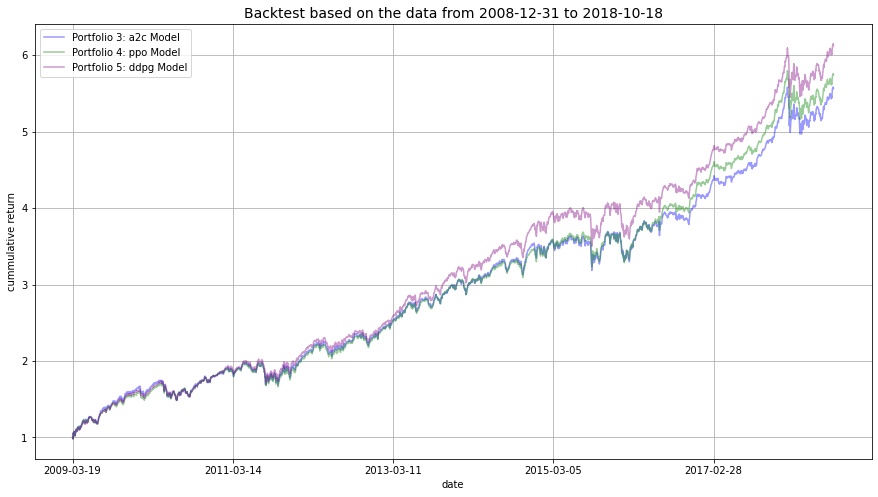

In [ ]:
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(15,8))

a2c_train_cum_returns.plot(ax=ax, color='blue', alpha=0.4)
ppo_train_cum_returns.plot(ax=ax, color='green', alpha=0.4)
ddpg_train_cum_returns.plot(ax=ax, color='purple', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("cummulative return");
ax.set_title("Backtest based on the data from 2008-12-31 to 2018-10-18", fontsize=14);
fig.savefig('results/back_test_on_train_data.png');

In [ ]:
a2c_test_cum_returns = (1 + a2c_test_returns['daily_return']).cumprod()
a2c_test_cum_returns.name = 'Portfolio 3: a2c Model'

ppo_test_cum_returns = (1 + ppo_test_returns['daily_return']).cumprod()
ppo_test_cum_returns.name = 'Portfolio 4: ppo Model'

ddpg_test_cum_returns = (1 + ddpg_test_returns['daily_return']).cumprod()
ddpg_test_cum_returns.name = 'Portfolio 5: ddpg Model'

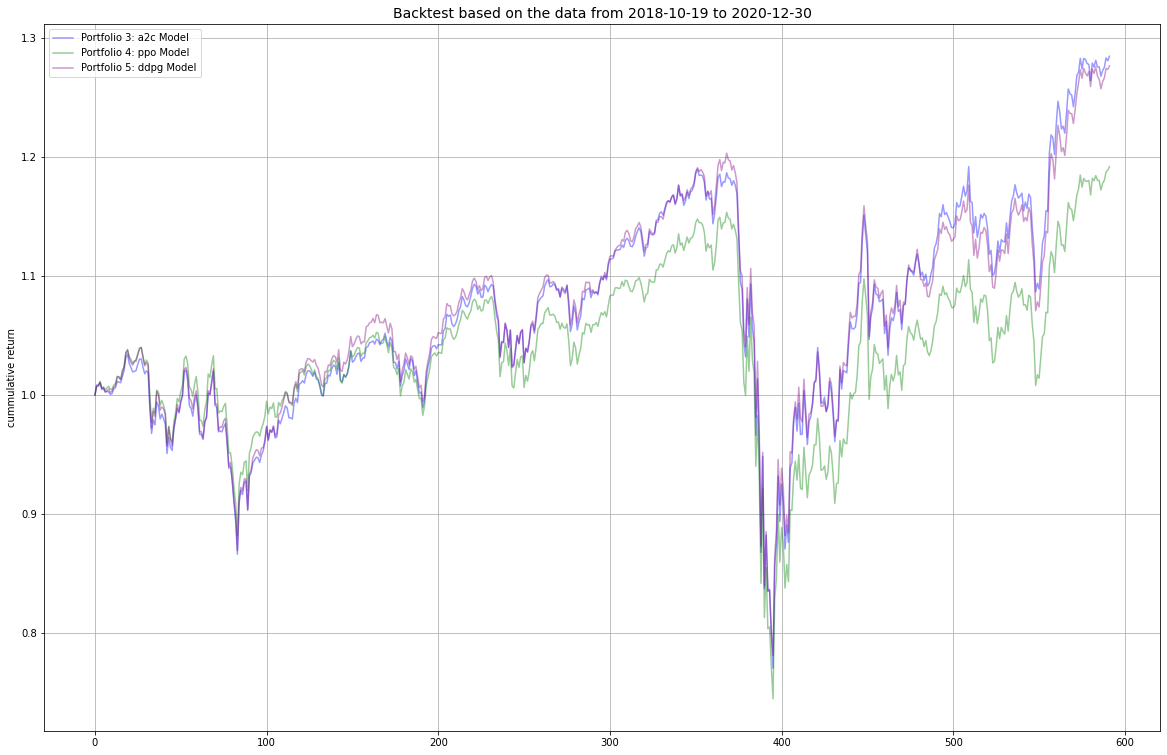

In [ ]:
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(20,13))
a2c_test_cum_returns.plot(ax=ax, color='blue', alpha=.4)
ppo_test_cum_returns.plot(ax=ax, color='green', alpha=.4)
ddpg_test_cum_returns.plot(ax=ax, color='purple', alpha=.4)
plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("cummulative return");
ax.set_title("Backtest based on the data from 2018-10-19 to 2020-12-30", fontsize=14);
fig.savefig('results/back_test_on_test_data.png');

In [ ]:
ddpg_test_weights

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2018-08-24,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2018-08-27,0.047281,0.017394,0.047281,0.017394,0.017394,0.017394,0.017394,0.047281,0.017394,0.047281,...,0.047281,0.017394,0.047281,0.047281,0.017394,0.047281,0.017394,0.047281,0.017394,0.017394
2018-08-28,0.047281,0.017394,0.047281,0.017394,0.017394,0.017394,0.017394,0.047281,0.017394,0.047281,...,0.047281,0.017394,0.047281,0.047281,0.017394,0.047281,0.017394,0.047281,0.017394,0.017394
2018-08-29,0.047281,0.017394,0.047281,0.017394,0.017394,0.017394,0.017394,0.047281,0.017394,0.047281,...,0.047281,0.017394,0.047281,0.047281,0.017394,0.047281,0.017394,0.047281,0.017394,0.017394
2018-08-30,0.047281,0.017394,0.047281,0.017394,0.017394,0.017394,0.017394,0.047281,0.017394,0.047281,...,0.047281,0.017394,0.047281,0.047281,0.017394,0.047281,0.017394,0.047281,0.017394,0.017394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.047281,0.017394,0.047281,0.017394,0.017394,0.017394,0.017394,0.047281,0.017394,0.047281,...,0.047281,0.017394,0.047281,0.047281,0.017394,0.047281,0.017394,0.047281,0.017394,0.017394
2020-12-24,0.047281,0.017394,0.047281,0.017394,0.017394,0.017394,0.017394,0.047281,0.017394,0.047281,...,0.047281,0.017394,0.047281,0.047281,0.017394,0.047281,0.017394,0.047281,0.017394,0.017394
2020-12-28,0.047281,0.017394,0.047281,0.017394,0.017394,0.017394,0.017394,0.047281,0.017394,0.047281,...,0.047281,0.017394,0.047281,0.047281,0.017394,0.047281,0.017394,0.047281,0.017394,0.017394


In [ ]:
# Define a Function for Getting the Portfolio Statistics

def portfolio_stats(portfolio_returns):
    # Pass the returns into a dataframe
    port_rets_df = pd.DataFrame(portfolio_returns)
    port_rets_df = port_rets_df.reset_index()
    port_rets_df.columns = ['date','daily_return']
    
    #Use the FinRL Library to get the Portfolio Returns
    #This makes use of the Pyfolio Library
    
    DRL_strat = backtest_strat(port_rets_df)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=DRL_strat, 
                                  factor_returns=DRL_strat, 
                                    positions=None, transactions=None, turnover_denom="AGB")
    perf_stats_all = pd.DataFrame( perf_stats_all)
    perf_stats_all.columns = ['Statistic']
    return perf_stats_all

In [ ]:
# Get the Portfolio Statistics for all the portfolios
portfolios_returns_dict = {'a2c Model': a2c_test_returns['daily_return'],
                          'ppo Model': ppo_test_returns['daily_return'],
                          'ddpg Model': ddpg_test_returns['daily_return']}

portfolios_stats = pd.DataFrame()
for i,j in portfolios_returns_dict.items():
    port_stats = portfolio_stats(j)
    portfolios_stats[i] = port_stats['Statistic']

In [ ]:
portfolios_stats

,a2c Model,ppo Model,ddpg Model
Annual return,0.112619,0.077606,0.109610
Cumulative returns,0.284923,0.191943,0.276776
Annual volatility,0.259180,0.260438,0.261827
Sharpe ratio,0.541739,0.417647,0.528733
Calmar ratio,0.319278,0.218880,0.312229
Stability,0.386596,0.111207,0.354699
Max drawdown,-0.352730,-0.354562,-0.351057
Omega ratio,1.122887,1.093557,1.119238
Sortino ratio,0.761836,0.583027,0.739594
Skew,-0.232136,-0.270694,-0.351156


# Ejercicios

- Comparar los resultados con Markovitz y la cartera de pesos iguales
- Probar con diferentes activos y temporalidad.


Fuentes:

- https://arxiv.org/pdf/2010.04404.pdf
- https://gym.openai.com/docs/
- **https://github.com/Musonda2day/Asset-Portfolio-Management-usingDeep-Reinforcement-Learning-**
- https://github.com/selimamrouni/Deep-Portfolio-Management-Reinforcement-Learning
- https://github.com/rathiromil13/DS-5500-Project-Portfolio-Optimization-Using-Deep-Reinforcement-Learning